In [1]:
# gesture_recog.ipynb

# The model is to train the guesture of images with the Leap Motion 
# T. Mantecón, C.R. del Blanco, F. Jaureguizar, N. García, “Hand Gesture Recognition using Infrared 
# Imagery Provided by Leap Motion Controller”, Int. Conf. on Advanced Concepts for Intelligent Vision
# Systems, ACIVS 2016, Lecce, Italy, pp. 47-57, 24-27 Oct. 2016. (doi: 10.1007/978-3-319-48680-2_5)

# Please download the leapgestrecog dataset from Kaggle. 
# https://www.kaggle.com/gti-upm/leapgestrecog

In [2]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
# -from keras import optimizers
import matplotlib.pyplot as plt
from alexnet import AlexNet
from keras.preprocessing import image

import numpy as np
import datetime
import os
import shutil
from PIL import Image
from numba import cuda

In [3]:
# Set up the GPU growth to avoid the sudden runtime error.

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
# Move the iamges from the original path to the source path 

# -import os
# -import shutil

orig_dir = '/home/mike/Documents/image_gesture/leapgestrecog/leapGestRecog'
src_dir  = '/home/mike/Documents/image_gesture/leapgestrecog/src_data'
if not os.path.exists(src_dir):
    os.makedirs(src_dir)

def move_data(orig_dir, src_dir):

    # Conduct three iterations with i, j and k counters
    for i in os.listdir(orig_dir):
        label = 0
        # Get the original category(ca) with i pointing to any folder from 00 to 09
        origca_dir = os.path.join(orig_dir, i)
        print("[MESSAGE] Category：%s %s"% (origca_dir,i))
        
        # The counter j points to any folder from 01_palm to 10_down. 
        for j in os.listdir(origca_dir):
            # The label is related to str(label) in the k iterations. 
            label = label + 1
            # Create the origcaty_dir and type(ty) represents the type of the above folders
            origcaty_dir = os.path.join(origca_dir, j)
            print("[MESSAGE] Type：    %s %s"% (origcaty_dir,j))
            
            for k in os.listdir(origcaty_dir):
                # origimg_path is the absolute path that holds the images such as frame_00_7_0001.png
                origimg_path = os.path.join(origcaty_dir, k)
                # Create the diretort for the label with str(label) ranging from 1 to 10
                srclbl_dir = os.path.join(src_dir, str(label))
                if not os.path.exists(srclbl_dir):
                    os.makedirs(srclbl_dir)
                # Create the absolute path 
                srcimg_path = os.path.join(srclbl_dir, k)
                 # Move the images 
                shutil.move(origimg_path, srcimg_path)
                
        print("[MESSAGE] Done：   ", origcaty_dir)
        
    print("[MESSAGE] All Done!")

if __name__ == '__main__':
    
    move_data(orig_dir, src_dir)

[MESSAGE] Category：/home/mike/Documents/image_gesture/leapgestrecog/leapGestRecog/06 06
[MESSAGE] Type：    /home/mike/Documents/image_gesture/leapgestrecog/leapGestRecog/06/03_fist 03_fist
[MESSAGE] Type：    /home/mike/Documents/image_gesture/leapgestrecog/leapGestRecog/06/08_palm_moved 08_palm_moved
[MESSAGE] Type：    /home/mike/Documents/image_gesture/leapgestrecog/leapGestRecog/06/06_index 06_index
[MESSAGE] Type：    /home/mike/Documents/image_gesture/leapgestrecog/leapGestRecog/06/09_c 09_c
[MESSAGE] Type：    /home/mike/Documents/image_gesture/leapgestrecog/leapGestRecog/06/10_down 10_down
[MESSAGE] Type：    /home/mike/Documents/image_gesture/leapgestrecog/leapGestRecog/06/01_palm 01_palm
[MESSAGE] Type：    /home/mike/Documents/image_gesture/leapgestrecog/leapGestRecog/06/05_thumb 05_thumb
[MESSAGE] Type：    /home/mike/Documents/image_gesture/leapgestrecog/leapGestRecog/06/02_l 02_l
[MESSAGE] Type：    /home/mike/Documents/image_gesture/leapgestrecog/leapGestRecog/06/04_fist_moved 0

In [5]:
# Divide the dataset into train, validation and tfile sets. 

# -import os
# -import shutil

# Designate source and division datasets
src_dir  = '/home/mike/Documents/image_gesture/leapgestrecog/src_data'
dset_dir = '/home/mike/Documents/image_gesture/dset_data'
if not os.path.exists(dset_dir):
    os.makedirs(dset_dir)
    

# Make three directories for training, validation and tfile(test file)
train_dir = os.path.join(dset_dir, 'train')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
    
val_dir = os.path.join(dset_dir, 'validation')
if not os.path.exists(val_dir):
    os.mkdir(val_dir)  

tfile_dir = os.path.join(dset_dir, 'tfile')
if not os.path.exists(tfile_dir):
    os.mkdir(tfile_dir)

    
for num in os.listdir(src_dir):
    # Folder 1~10
    train_idx_dir = os.path.join(train_dir, num)
    if not os.path.exists(train_idx_dir):
        os.mkdir(train_idx_dir)
        
    val_idx_dir = os.path.join(val_dir, num)
    if not os.path.exists(val_idx_dir):
        os.mkdir(val_idx_dir)
        
    tfile_idx_dir = os.path.join(tfile_dir, num)
    if not os.path.exists(tfile_idx_dir):
        os.mkdir(tfile_idx_dir)
        
    # Index is increasing. 
    src_idx_dir = os.path.join(src_dir, num)
    
    # print(src_idx_dir)

    j = 0
    
    for fname in os.listdir(src_idx_dir): 
        
        if j < 1000:  # Copy 1000 images to the train directory
            src = os.path.join(src_idx_dir, fname)
            dst = os.path.join(train_idx_dir, fname)
            shutil.copyfile(src, dst)
        elif (j >= 1000 and j < 1500):  # Copy 500 images to the val directory
            src = os.path.join(src_idx_dir, fname)
            dst = os.path.join(val_idx_dir, fname)
            shutil.copyfile(src, dst)
        elif (j >= 1500):  # Copy 500 images to the test directory
            src = os.path.join(src_idx_dir, fname)
            dst = os.path.join(tfile_idx_dir, fname)
            shutil.copyfile(src, dst)
            
        j = j + 1
        
    print("[MESSAGE] Copy completed :", train_idx_dir)
    print("[MESSAGE] Copy completed :", val_idx_dir)
    print("[MESSAGE] Copy completed :", tfile_idx_dir)


print('[MESSAGE] Train folders:', len(os.listdir(train_dir)))
print('[MESSAGE] Validation folders:', len(os.listdir(val_dir)))
print('[MESSAGE] Tfile folders:', len(os.listdir(tfile_dir)))

print('[MESSAGE] Train images per folder:', len(os.listdir(train_dir+"/1/")))
print('[MESSAGE] Validation images per folder:', len(os.listdir(val_dir+"/1/")))
print('[MESSAGE] Tfile images per folder:', len(os.listdir(tfile_dir+"/1/")))

[MESSAGE] Copy completed : /home/mike/Documents/image_gesture/dset_data/train/3
[MESSAGE] Copy completed : /home/mike/Documents/image_gesture/dset_data/validation/3
[MESSAGE] Copy completed : /home/mike/Documents/image_gesture/dset_data/tfile/3
[MESSAGE] Copy completed : /home/mike/Documents/image_gesture/dset_data/train/10
[MESSAGE] Copy completed : /home/mike/Documents/image_gesture/dset_data/validation/10
[MESSAGE] Copy completed : /home/mike/Documents/image_gesture/dset_data/tfile/10
[MESSAGE] Copy completed : /home/mike/Documents/image_gesture/dset_data/train/5
[MESSAGE] Copy completed : /home/mike/Documents/image_gesture/dset_data/validation/5
[MESSAGE] Copy completed : /home/mike/Documents/image_gesture/dset_data/tfile/5
[MESSAGE] Copy completed : /home/mike/Documents/image_gesture/dset_data/train/7
[MESSAGE] Copy completed : /home/mike/Documents/image_gesture/dset_data/validation/7
[MESSAGE] Copy completed : /home/mike/Documents/image_gesture/dset_data/tfile/7
[MESSAGE] Copy co

In [6]:
# Shift the dataset from tfile_dir to test_dir with only one subsidiary folder

# -import os
# -import shutil

tfile_dir =  '/home/mike/Documents/image_gesture/dset_data/tfile'
test_dir  =  '/home/mike/Documents/image_gesture/dset_data/test'
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

def shift_data(tfile_dir, test_dir):

    for i in os.listdir(tfile_dir):
        tfca_dir = os.path.join(tfile_dir, i)
        
        for j in os.listdir(tfca_dir):
            tfcaimg_path = os.path.join(tfca_dir, j)
            tfol_dir = os.path.join(test_dir, 'folder')
            if not os.path.exists(tfol_dir):
                os.makedirs(tfol_dir)
            tfolimg_path = os.path.join(tfol_dir, j)
            shutil.move(tfcaimg_path, tfolimg_path)

if __name__ == '__main__':

    shift_data(tfile_dir, test_dir)

In [7]:
# Assign the global arguments 

EPOCHS = 32
BATCH_SIZE = 100
image_width = 227
image_height = 227
channels = 3
num_classes = 10

In [8]:
# Call the AlexNet model 

model = AlexNet((image_width,image_height,channels), num_classes)

In [9]:
# Compile the Model with RMSprop and categorical_crossentropy for ten classes

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='categorical_crossentropy', 
              metrics=['acc'])

In [10]:
# Summary

model.summary()

Model: "alex_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 384)       885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 384)       1327488   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 256)       884

In [11]:
# Preprocess the augumented images

train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(image_width,image_height),
                                                    batch_size=BATCH_SIZE,
                                                    seed=1,
                                                    shuffle=True,
                                                    class_mode='categorical')

train_num = train_generator.samples


test_datagen = ImageDataGenerator(rescale=1.0/255)

val_generator = test_datagen.flow_from_directory(val_dir,
                                                 target_size=(image_width,image_height),
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='categorical')

val_num = val_generator.samples

Found 10000 images belonging to 10 classes.
Found 5000 images belonging to 10 classes.


In [12]:
# Get the batch shape

for data_batch, label_batch in train_generator:
    print("data batch shape:", data_batch.shape)
    print("label batch shape:", label_batch)
    
    break

data batch shape: (100, 227, 227, 3)
label batch shape: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 

In [13]:
# 8.Tain the model
history = model.fit(train_generator,
                    steps_per_epoch=train_num//BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=val_generator,
                    validation_steps=val_num//BATCH_SIZE)

Epoch 1/32
100/100 [==============================] - 82s 820ms/step - loss: 2.4491 - acc: 0.2609 - val_loss: 0.8546 - val_acc: 0.6616
Epoch 2/32
100/100 [==============================] - 81s 814ms/step - loss: 0.4741 - acc: 0.8207 - val_loss: 0.0756 - val_acc: 0.9808
Epoch 3/32
100/100 [==============================] - 81s 812ms/step - loss: 0.1768 - acc: 0.9430 - val_loss: 0.0621 - val_acc: 0.9818
Epoch 4/32
100/100 [==============================] - 81s 813ms/step - loss: 0.0966 - acc: 0.9682 - val_loss: 0.0251 - val_acc: 0.9946
Epoch 5/32
100/100 [==============================] - 81s 814ms/step - loss: 0.0727 - acc: 0.9779 - val_loss: 0.0149 - val_acc: 0.9974
Epoch 6/32
100/100 [==============================] - 81s 812ms/step - loss: 0.0502 - acc: 0.9868 - val_loss: 0.0334 - val_acc: 0.9896
Epoch 7/32
100/100 [==============================] - 81s 812ms/step - loss: 0.0518 - acc: 0.9853 - val_loss: 0.0151 - val_acc: 0.9978
Epoch 8/32
100/100 [==============================] - 8

In [14]:
# Save the model 

model.save('/home/mike/Documents/image_gesture/leapGestRecog_small_aug_categorical.h5')

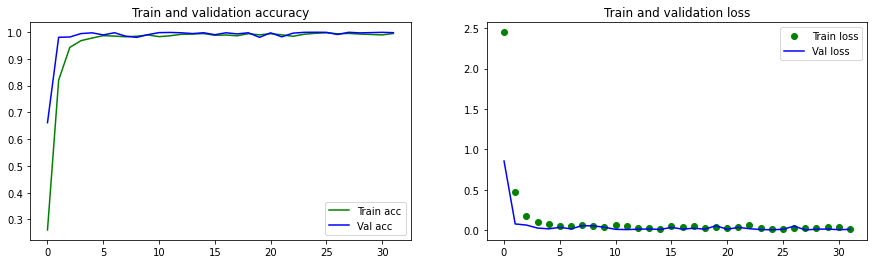

In [15]:
# Evaluate the model with visulizing the result 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b', label='Train acc', color='green')
plt.plot(epochs, val_acc, 'b', label='Val acc')
plt.title('Train and validation accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo', label='Train loss', color='green')
plt.plot(epochs, val_loss, 'b', label='Val loss')
plt.title('Train and validation loss')
plt.legend()

plt.show()

In [16]:
# Release the GPU memory 

cuda.select_device(0)
cuda.close()